# Entrega 19: Feature selection, entrenamiento de datos y cálculo de métricas para validar el modelo

In [68]:
#Importaciones
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Lectura dataset "healthcare-dataset-stroke-data.csv"

In [69]:
#Leemos dataset descargado desde aquí: https://gist.github.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04#file-healthcare-dataset-stroke-data-csv
df_stroke = pd.read_csv('datasets/healthcare-dataset-stroke-data.csv')
df_stroke['age']=df_stroke['age'].round(0).astype(int)



#Reemplazamos nulos
df_stroke.fillna(df_stroke.mean(),inplace=True)
df_stroke.isnull().values.any()
df_stroke.isnull().sum

#Cambiamos valores string por numéricos
df_stroke['gender'] = df_stroke['gender'].replace('Female',0)
df_stroke['gender'] = df_stroke['gender'].replace('Male',1)
df_stroke['gender'] = df_stroke['gender'].replace('Other',0)

df_stroke['ever_married'] = df_stroke['ever_married'].replace('Yes',1)
df_stroke['ever_married'] = df_stroke['ever_married'].replace('No',0)

df_stroke['work_type'] = df_stroke['work_type'].replace('Never_worked',0)
df_stroke['work_type'] = df_stroke['work_type'].replace('Private',1)
df_stroke['work_type'] = df_stroke['work_type'].replace('Self-employed',2)
df_stroke['work_type'] = df_stroke['work_type'].replace('Govt_job',3)
df_stroke['work_type'] = df_stroke['work_type'].replace('children',4)

df_stroke['Residence_type'] = df_stroke['Residence_type'].replace('Urban',1)
df_stroke['Residence_type'] = df_stroke['Residence_type'].replace('Rural',0)

df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('never smoked',0)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('smokes',1)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('formerly smoked',2)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('Unknown',3)
display(df_stroke)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67,0,1,1,1,1,228.69,36.600000,2,1
1,51676,0,61,0,0,1,2,0,202.21,28.893237,0,1
2,31112,1,80,0,1,1,1,0,105.92,32.500000,0,1
3,60182,0,49,0,0,1,1,1,171.23,34.400000,1,1
4,1665,0,79,1,0,1,2,0,174.12,24.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80,1,0,1,1,1,83.75,28.893237,0,0
5106,44873,0,81,0,0,1,2,1,125.20,40.000000,0,0
5107,19723,0,35,0,0,1,2,0,82.99,30.600000,0,0
5108,37544,1,51,0,0,1,1,0,166.29,25.600000,2,0


Preparamos los datos en una matriz con las features y en otra sólo con el target

In [70]:
df_test=df_stroke.copy()
X = df_test.drop(["stroke","id"],1) #Matriz con las features
y = df_test['stroke'] #Matriz sólo con el target

## Forward Selection

Nos decantamos por el método forward selection.

In [ ]:
%pip install joblib
%pip install mlxtend
%pip install sklearn

In [72]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [73]:
#Librerias
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=6,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 2)

sfs.fit(X, y)
sfs.k_feature_names_     #Lista final de features

('gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type')

In [74]:
# Creamos las features con las columnas que nos sugiere este algoritmo

X = X[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi']]

De este método se saca que los campos relevantes para el cálculo del modelo son 6: Edad, hipertensión, enfermedad cardíaca previa, si está casado, la media de glucosa y el índice de masa corporal

## Entrenamiento, validación y test datasets

In [75]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [76]:
train, test = np.split(df_stroke.sample(frac=1),[int(0.8*len(df_stroke))])

In [77]:
def scale_dataset (dataframe, oversample=False):
  dataframe = dataframe[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','stroke']]
  x = dataframe.drop(["stroke"],1).values
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe['stroke'].values

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  data = np.hstack((x, np.reshape(y, (-1, 1))))

  return data, x, y

In [78]:
train, x_train, y_train = scale_dataset (train, oversample=True)
test, x_test, y_test = scale_dataset (test, oversample=False)

## Métricas

In [79]:
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Utilizamos el modelo KNN. Se detalla el análisis por modelo en la entrega extra

In [80]:
# Creamos un modelo KNN con parametros por defecto
modelo = neighbors.KNeighborsClassifier(n_neighbors=2) 
modelo.fit(x_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(x_test) 

<Figure size 2000x1200 with 0 Axes>

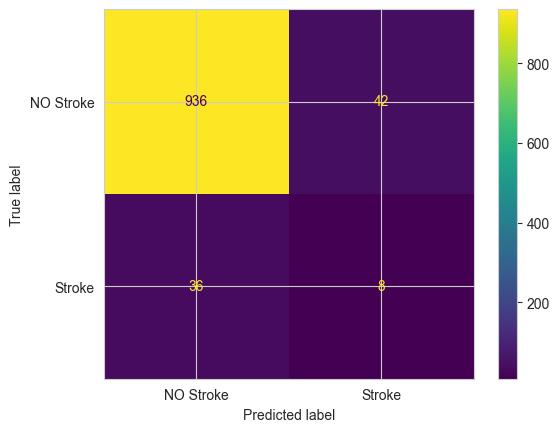

In [87]:
plt.figure(figsize=(20,12));
metrics.plot_confusion_matrix(modelo, x_test, y_test, display_labels=['NO Stroke', 'Stroke']);

In [82]:
confusion = metrics.confusion_matrix(y_test, preds)
confusion.ravel()
accuracy = metrics.accuracy_score(y_test, preds)
accuracy 

0.923679060665362

In [83]:
# Precision se evalua para cada categoria
precision_positiva = metrics.precision_score(y_test, preds, pos_label=1)
precision_negativa = metrics.precision_score(y_test, preds, pos_label=0)
precision_positiva, precision_negativa 

(0.16, 0.9629629629629629)

In [84]:
recall_sensibilidad = metrics.recall_score(y_test, preds, pos_label=1)
recall_especificidad= metrics.recall_score(y_test, preds, pos_label=0)
recall_sensibilidad, recall_especificidad

(0.18181818181818182, 0.9570552147239264)

In [85]:
f1_positivo = metrics.f1_score(y_test, preds, pos_label=1)
f1_negativo = metrics.f1_score(y_test, preds, pos_label=0)
f1_positivo, f1_negativo 

(0.1702127659574468, 0.9599999999999999)

In [86]:
# Todas las metricas en uno
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       978
           1       0.16      0.18      0.17        44

    accuracy                           0.92      1022
   macro avg       0.56      0.57      0.57      1022
weighted avg       0.93      0.92      0.93      1022



## Conclusiones

Con los parámetros que hemos usado es casi imposible obtener un dato concluyente.

Se han seguido los siguientes procesos:

- Manipulación del dataset cambiando los valores alfanuméricos por integers.
- Se utiliza forward selection para obtener las variables.
- Con estas variables, se generan datasets para entrenamiento y para el testeo. Estos datasets están oversampleados para intentar tener más valores de cada tipo de target.
- Se utiliza el modelo KNN.

Los datos que arroja el modelo nos dan un 16% de precisión a la hora de detectar un posible paciente que padecerá un ataque al corazón. Con estos resultados es imposible preveer nada correctamente. ¿Tendremos que usar otros modelos? En la entrega complementaria se hace un análisis de cada uno de ellos.
